In [1]:
RKP = "DL031"
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
sns.set_theme(style="darkgrid")

In [2]:
# Load datasets and rename columns, load all aqi data but specify metro data name
def loadcsv(city="./data/rkpuram.csv"):
    met = pd.read_csv(city,delimiter=';',skiprows=24)
    aqi = pd.read_csv('./data/station_hour.csv')
    print(aqi.columns)
    met.rename(columns={'# Date': 'Date',}, inplace=True)
    met.rename(columns={'UT time': 'Time',}, inplace=True)
    aqi['Time'] = aqi['Datetime'].str[-8:-3]
    aqi['Date'] = aqi['Datetime'].str[0:10]
    stations = ["DL"+str(x).zfill(3) for x in range(1,39)]
    split_aqi = {}
    for i in range(len(stations)):
        split_aqi[stations[i]] = (aqi[aqi['StationId'] == stations[i]])
    return met,aqi,split_aqi
met,aqi,split_aqi = loadcsv()

C:\Users\confusement\miniconda3\envs\mlc\lib\site-packages\IPython\core\interactiveshell.py:3263: DtypeWarning: Columns (15) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


Index(['StationId', 'Datetime', 'PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3',
       'CO', 'SO2', 'O3', 'Benzene', 'Toluene', 'Xylene', 'AQI', 'AQI_Bucket'],
      dtype='object')


In [32]:
# Pre - processing and loading data
class dataset:
    def __init__(self,met,aqi,split_aqi):
            self.metro_data = met
            self.aqi_data = aqi
            self.split_aqi = split_aqi
    def mergedData(self,station,rlist=['PM2.5','PM10','NO','NO2','NOx','NH3','CO','SO2','O3'],roll=48,shift=48):
        df_aqi = self.getdf(station)
        df = pd.merge(df_aqi, self.metro_data, how='inner', on=['Date', 'Time'])
        print("Merged Dataset Size",len(df))
        
        #Pre Processing merged Data
        df['Year'] = df['Date'].str[0:4]
        df['Month'] = df['Date'].str[5:7].astype(np.float64)
        df['Day'] = df['Date'].str[8:10].astype(np.float64)
        df['Hour'] = df['Time'].str[0:2]
        
        # TRIG TRANSFORMATIONS
        df['windX'] = np.cos(np.deg2rad(df['Wind direction'])) * df['Wind speed']
        df['windY'] = np.sin(np.deg2rad(df['Wind direction'])) * df['Wind speed']
        df['hourX'] = np.cos((df['Hour'].astype(np.float64)-1)*np.pi/24)
        df['hourY'] = np.sin((df['Hour'].astype(np.float64)-1)*np.pi/24)
        df['MonthX'] = np.cos((df['Month'].astype(np.float64)-1)*np.pi/12)
        df['MonthY'] = np.sin((df['Month'].astype(np.float64)-1)*np.pi/12)
        
        import datetime
        df['Date'] = pd.to_datetime(df['Date'])
        df['isWeekend'] =  (df['Date'].dt.dayofweek>=5).astype(int)
        
        df.interpolate(method='linear', limit=5,inplace=True)
        
        # Drop Additional columns
        df.drop('Benzene', axis=1, inplace=True)
        df.drop('Toluene',axis=1, inplace=True)
        df.drop('Xylene', axis=1,inplace=True)
        df.drop('AQI_Bucket',axis=1,inplace=True)
        df.drop('Datetime',axis=1,inplace=True)
        df.drop('StationId',axis=1,inplace=True)
        df.drop('Short-wave irradiation',axis=1,inplace=True)
        df.drop('Date',axis=1,inplace=True)
        df.drop('Time',axis=1,inplace=True)
        
        # Rolling and shifting 
        print("Size before roll",len(df))
        for i in rlist:
            df[i+'_lag1'] = df[i].shift(24)
            df[i+'_lag2'] = df[i].shift(48)
        for i in rlist:
            df[i+"_pred1"] = df[i].shift(-24)
            df[i+"_pred2"] = df[i].shift(-48)
        for i in rlist:
            for j in range(24):
                df[i+"_t-"+str(j)] = df[i].shift(j)
                df[i+"_t+"+str(j)] = df[i].shift(-j-shift)
        df.dropna(inplace=True)
        print("Size after roll",len(df))
        
        return df.copy()
    def getdf(self,station):
        return self.split_aqi[station]
    def plot(self,station):
        df = self.getdf(station)
    def stats(self):
        pass
dat = dataset(met,aqi,split_aqi)
df = dat.mergedData('DL031')
df

Merged Dataset Size 44035
Size before roll 44035
Size after roll 14861


,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,AQI,...,O3_t-19,O3_t+19,O3_t-20,O3_t+20,O3_t-21,O3_t+21,O3_t-22,O3_t+22,O3_t-23,O3_t+23
165,33.00,102.17,6.33,14.45,22.22,23.65,0.17,10.27,18.08,429.0,...,26.83,39.17,19.83,34.33,18.75,32.58,19.58,32.58,21.33,34.42
166,95.17,184.83,6.72,15.63,23.86,22.06,20.00,11.97,18.58,429.0,...,35.33,34.33,26.83,32.58,19.83,32.58,18.75,34.42,19.58,34.75
167,77.50,164.67,8.15,32.28,41.18,26.91,8.00,17.28,20.33,318.0,...,43.58,32.58,35.33,32.58,26.83,34.42,19.83,34.75,18.75,38.33
168,65.50,154.33,7.64,90.45,94.00,30.74,17.00,18.81,29.83,318.0,...,52.17,32.58,43.58,34.42,35.33,34.75,26.83,38.33,19.83,46.50
170,60.50,310.17,14.19,116.38,121.56,28.73,15.00,15.16,33.33,318.0,...,59.83,34.75,56.42,38.33,52.17,46.50,43.58,55.92,35.33,56.92
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43959,45.00,173.00,1.97,10.47,7.20,26.23,0.60,14.25,8.98,96.0,...,7.30,8.80,6.05,11.10,11.80,12.57,10.88,12.40,10.25,14.65
43960,66.00,250.00,2.55,19.05,12.20,23.60,0.65,14.43,7.52,102.0,...,7.30,11.10,7.30,12.57,6.05,12.40,11.80,14.65,10.88,11.53
43961,56.00,183.00,3.25,28.25,17.70,28.57,0.80,18.93,10.67,105.0,...,8.10,12.57,7.30,12.40,7.30,14.65,6.05,11.53,11.80,10.25
43962,63.00,190.00,4.03,44.83,27.15,38.50,0.82,18.10,7.38,108.0,...,9.43,12.40,8.10,14.65,7.30,11.53,7.30,10.25,6.05,10.05


In [34]:
from sklearn.feature_selection import SelectKBest, chi2, f_classif, f_regression , mutual_info_regression
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
dfTrain = df[:]
features = ['Temperature','Relative Humidity','windX','windY','Year','MonthX','MonthY','hourX','hourY','isWeekend']
features.append("PM2.5_lag1")
features.append("PM2.5_lag2")

features.append("PM10_lag1")
features.append("PM10_lag2")

features.append("NO2_lag1")
features.append("NO2_lag2")

features.append("SO2_lag1")
features.append("SO2_lag2")

features.append("CO_lag1")
features.append("CO_lag2")
X = df[features]
y = df['PM2.5_pred1']
scaler = StandardScaler()
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.33, random_state=42)
scaler.fit(Xtrain)

reg = LinearRegression().fit(scaler.transform(Xtrain), ytrain)

testPred = reg.predict(scaler.transform(Xtest))
trainPred = reg.predict(scaler.transform(Xtrain))
mse = np.mean((testPred - np.array(ytest))*(testPred - np.array(ytest)))
print(reg.score(scaler.transform(Xtest), ytest))
print(mean_squared_error(testPred, ytest,squared=False))
print(mean_squared_error(trainPred, ytrain,squared=False))

0.4613403329888863
60.96974796032171
63.05849255749911


In [35]:
from sklearn.feature_selection import SelectKBest, chi2, f_classif, f_regression , mutual_info_regression
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
dfTrain = df[:]
features = ['Temperature','Relative Humidity','windX','windY','Year','MonthX','MonthY','hourX','hourY','isWeekend']
features.append("PM2.5_lag1")
features.append("PM2.5_lag2")

features.append("PM10_lag1")
features.append("PM10_lag2")

features.append("NO2_lag1")
features.append("NO2_lag2")

features.append("SO2_lag1")
features.append("SO2_lag2")

features.append("CO_lag1")
features.append("CO_lag2")
X = df[features]
y = df['PM2.5_pred1']
scaler = StandardScaler()
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.33, random_state=42)
scaler.fit(Xtrain)

reg = MLPRegressor(random_state=1, max_iter=100).fit(scaler.transform(Xtrain), ytrain)

testPred = reg.predict(scaler.transform(Xtest))
trainPred = reg.predict(scaler.transform(Xtrain))
mse = np.mean((testPred - np.array(ytest))*(testPred - np.array(ytest)))
print(reg.score(scaler.transform(Xtest), ytest))
print(mean_squared_error(testPred, ytest,squared=False))
print(mean_squared_error(trainPred, ytrain,squared=False))

0.5366752515515851
56.54574363812652
57.906774033167665


C:\Users\confusement\miniconda3\envs\mlc\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [36]:
from sklearn.feature_selection import SelectKBest, chi2, f_classif, f_regression , mutual_info_regression
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
dfTrain = df[:]
features = ['Temperature','Relative Humidity','windX','windY','Year','MonthX','MonthY','hourX','hourY','isWeekend']
features.append("PM2.5_lag1")
features.append("PM2.5_lag2")

features.append("PM10_lag1")
features.append("PM10_lag2")

features.append("NO2_lag1")
features.append("NO2_lag2")

features.append("SO2_lag1")
features.append("SO2_lag2")

features.append("CO_lag1")
features.append("CO_lag2")
X = df[features]
y = df['PM2.5_pred1']
scaler = StandardScaler()
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.33, random_state=42)
scaler.fit(Xtrain)

reg = SVR(C=1.0, epsilon=0.2).fit(scaler.transform(Xtrain), ytrain)

testPred = reg.predict(scaler.transform(Xtest))
trainPred = reg.predict(scaler.transform(Xtrain))
mse = np.mean((testPred - np.array(ytest))*(testPred - np.array(ytest)))
print(reg.score(scaler.transform(Xtest), ytest))
print(mean_squared_error(testPred, ytest,squared=False))
print(mean_squared_error(trainPred, ytrain,squared=False))

0.3778398185894405
65.52518818123579
66.79772066299263


In [37]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [29]:
from keras.models import Sequential
from keras.layers import Dense
for j in range(24):
    features.append('PM2.5_t-'+str(j))
predVector = []
for j in range(24):
    predVector.append('PM2.5_t+'+str(j))
X = df[features]
y = df['PM2.5_t+23']
scaler = StandardScaler()
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.33, random_state=42)
scaler.fit(Xtrain)
with tf.device('/CPU:0'):
    model = Sequential()
    model.add(Dense(50, input_dim=34, kernel_initializer='normal', activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(24, activation='linear'))
    model.summary()
    #Fit
    model.compile(loss='mse', optimizer='adam', metrics=['mse','mae'])
    history = model.fit(scaler.transform(Xtrain), ytrain, epochs=250, batch_size=50,  verbose=1, validation_split=0.2)
    #Print Accuracy
    testPred = model.predict(scaler.transform(Xtest))
    trainPred = model.predict(scaler.transform(Xtrain))
    print(mean_squared_error(testPred, ytest,squared=False))
    print(mean_squared_error(trainPred, ytrain,squared=False))

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_27 (Dense)             (None, 50)                1750      
_________________________________________________________________
dense_28 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_29 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_30 (Dense)             (None, 24)                1224      
Total params: 8,074
Trainable params: 8,074
Non-trainable params: 0
_________________________________________________________________
Train on 9168 samples, validate on 2293 samples
Epoch 1/250
9168/9168 [==============================] - 0s 51us/step - loss: 10501.2033 - mse: 10501.2080 - mae: 72.9954 - val_loss: 5702.4121 - val_mse: 5702.4111 - val_mae: 51.5703
Epoch 2/250
9168/9

Epoch 41/250
9168/9168 [==============================] - 0s 49us/step - loss: 3003.1233 - mse: 3003.1235 - mae: 37.3832 - val_loss: 3010.6117 - val_mse: 3010.6121 - val_mae: 37.4309
Epoch 42/250
9168/9168 [==============================] - 1s 60us/step - loss: 2988.1373 - mse: 2988.1382 - mae: 37.2508 - val_loss: 3026.2134 - val_mse: 3026.2136 - val_mae: 38.2478
Epoch 43/250
9168/9168 [==============================] - 0s 48us/step - loss: 2962.5517 - mse: 2962.5522 - mae: 37.0384 - val_loss: 3014.5280 - val_mse: 3014.5276 - val_mae: 38.1166
Epoch 44/250
9168/9168 [==============================] - 0s 39us/step - loss: 2948.8334 - mse: 2948.8330 - mae: 37.0295 - val_loss: 2951.5256 - val_mse: 2951.5256 - val_mae: 37.2895
Epoch 45/250
9168/9168 [==============================] - 0s 36us/step - loss: 2940.9697 - mse: 2940.9702 - mae: 36.9538 - val_loss: 2961.4965 - val_mse: 2961.4968 - val_mae: 37.3088
Epoch 46/250
9168/9168 [==============================] - 0s 36us/step - loss: 2938.7

Epoch 85/250
9168/9168 [==============================] - 1s 73us/step - loss: 2618.6328 - mse: 2618.6331 - mae: 35.1310 - val_loss: 2877.4049 - val_mse: 2877.4050 - val_mae: 37.2140
Epoch 86/250
9168/9168 [==============================] - 1s 73us/step - loss: 2613.7019 - mse: 2613.7024 - mae: 35.0753 - val_loss: 2836.6697 - val_mse: 2836.6697 - val_mae: 36.4057
Epoch 87/250
9168/9168 [==============================] - 1s 70us/step - loss: 2602.9707 - mse: 2602.9700 - mae: 35.0452 - val_loss: 2846.9951 - val_mse: 2846.9949 - val_mae: 36.6187
Epoch 88/250
9168/9168 [==============================] - 1s 68us/step - loss: 2622.0805 - mse: 2622.0813 - mae: 35.1701 - val_loss: 2836.7969 - val_mse: 2836.7969 - val_mae: 36.4585
Epoch 89/250
9168/9168 [==============================] - 1s 61us/step - loss: 2602.2658 - mse: 2602.2659 - mae: 35.0589 - val_loss: 2939.7009 - val_mse: 2939.7009 - val_mae: 36.4563
Epoch 90/250
9168/9168 [==============================] - 1s 58us/step - loss: 2595.9

9168/9168 [==============================] - 1s 73us/step - loss: 2385.6269 - mse: 2385.6265 - mae: 33.7667 - val_loss: 2731.3303 - val_mse: 2731.3306 - val_mae: 36.0417
Epoch 130/250
9168/9168 [==============================] - 1s 70us/step - loss: 2373.2565 - mse: 2373.2563 - mae: 33.6930 - val_loss: 2754.0957 - val_mse: 2754.0955 - val_mae: 35.7909
Epoch 131/250
9168/9168 [==============================] - 1s 71us/step - loss: 2379.2059 - mse: 2379.2061 - mae: 33.7027 - val_loss: 2722.4283 - val_mse: 2722.4282 - val_mae: 35.6957
Epoch 132/250
9168/9168 [==============================] - 1s 71us/step - loss: 2385.4101 - mse: 2385.4099 - mae: 33.7058 - val_loss: 2781.5071 - val_mse: 2781.5073 - val_mae: 36.2383
Epoch 133/250
9168/9168 [==============================] - 1s 70us/step - loss: 2369.8431 - mse: 2369.8438 - mae: 33.6093 - val_loss: 2765.4204 - val_mse: 2765.4204 - val_mae: 36.4668
Epoch 134/250
9168/9168 [==============================] - 1s 74us/step - loss: 2351.2236 - ms

9168/9168 [==============================] - 0s 53us/step - loss: 2238.3944 - mse: 2238.3943 - mae: 32.8173 - val_loss: 2751.7345 - val_mse: 2751.7346 - val_mae: 36.2424
Epoch 174/250
9168/9168 [==============================] - 0s 47us/step - loss: 2225.1398 - mse: 2225.1404 - mae: 32.7369 - val_loss: 2682.1276 - val_mse: 2682.1277 - val_mae: 35.6291
Epoch 175/250
9168/9168 [==============================] - 0s 36us/step - loss: 2224.9483 - mse: 2224.9478 - mae: 32.7175 - val_loss: 2746.6447 - val_mse: 2746.6450 - val_mae: 35.7569
Epoch 176/250
9168/9168 [==============================] - 1s 67us/step - loss: 2239.4403 - mse: 2239.4404 - mae: 32.8012 - val_loss: 2742.0375 - val_mse: 2742.0374 - val_mae: 35.5209
Epoch 177/250
9168/9168 [==============================] - 1s 55us/step - loss: 2225.3133 - mse: 2225.3127 - mae: 32.7366 - val_loss: 2704.9229 - val_mse: 2704.9229 - val_mae: 35.3284
Epoch 178/250
9168/9168 [==============================] - 1s 67us/step - loss: 2234.5268 - ms

9168/9168 [==============================] - 1s 82us/step - loss: 2093.6962 - mse: 2093.6958 - mae: 31.9016 - val_loss: 2670.9476 - val_mse: 2670.9478 - val_mae: 35.0936
Epoch 218/250
9168/9168 [==============================] - 1s 78us/step - loss: 2093.4631 - mse: 2093.4639 - mae: 31.8458 - val_loss: 2687.7582 - val_mse: 2687.7581 - val_mae: 35.3756
Epoch 219/250
9168/9168 [==============================] - 1s 76us/step - loss: 2110.2495 - mse: 2110.2495 - mae: 32.0144 - val_loss: 2820.4816 - val_mse: 2820.4814 - val_mae: 35.3900
Epoch 220/250
9168/9168 [==============================] - 1s 80us/step - loss: 2094.8810 - mse: 2094.8804 - mae: 31.8554 - val_loss: 2632.8920 - val_mse: 2632.8921 - val_mae: 35.3026
Epoch 221/250
9168/9168 [==============================] - 1s 77us/step - loss: 2110.4819 - mse: 2110.4817 - mae: 31.9713 - val_loss: 2676.3929 - val_mse: 2676.3931 - val_mae: 35.7487
Epoch 222/250
9168/9168 [==============================] - 1s 78us/step - loss: 2090.8763 - ms

dict_keys(['val_loss', 'val_mse', 'val_mae', 'loss', 'mse', 'mae'])


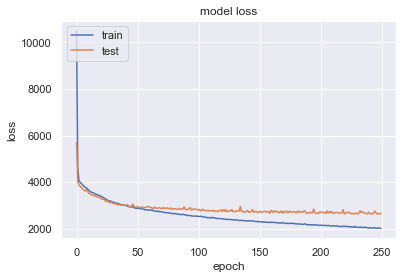

In [30]:
import matplotlib.pyplot as plt
# list all data in history
print(history.history.keys())
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()